### Wrangle and Analyze Data


In [238]:
# importing required libraries
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import json
import requests
import tweepy
from tweepy import OAuthHandler
import os
import re
import seaborn as sns
from timeit import default_timer as timer
import random
%matplotlib inline
import time
import datetime
from sqlalchemy import create_engine

In [239]:
#Read CSV file 
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive_df.sort_values('timestamp')
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [240]:
list(twitter_archive_df)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

# Gather data


#### image prediction

In [241]:
#downloaded image prediction(URL)programatically 
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
file_name = url.split('/')[-1]
response


<Response [200]>

In [242]:

if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(response.content)
        
image_predictions_df = pd.read_csv(file_name, sep='\t')
image_predictions_df.head()


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


# API


In [243]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
if not os.path.isfile('tweet_json.txt'):
    with open('tweet_json.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
end = timer()
print(end - start)
print(fails_dict)

0.000691400004143361
{}


In [244]:
# list of dictionaries
tweets_data = []

with open('tweet_json.txt', 'r') as f:
    for line in f:
        tweet_data = json.loads(line)
        tweets_data.append(tweet_data)
        
api_df = pd.DataFrame(tweets_data)


In [245]:
list(api_df)

['created_at',
 'id',
 'id_str',
 'full_text',
 'truncated',
 'display_text_range',
 'entities',
 'extended_entities',
 'source',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name',
 'user',
 'geo',
 'coordinates',
 'place',
 'contributors',
 'is_quote_status',
 'retweet_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'possibly_sensitive',
 'possibly_sensitive_appealable',
 'lang',
 'retweeted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status']

In [246]:
api_df = api_df[['id', 'retweet_count', 'favorite_count']]

In [247]:
api_df.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [248]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


# Assess Data

# 
Programmatic assessment

In [249]:
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [250]:
twitter_archive_df.tweet_id.duplicated().any()

False

In [251]:
twitter_archive_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [252]:

twitter_archive_df[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [253]:

twitter_archive_df.query('rating_denominator != 10')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the flo...,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
784,"RT @dog_rates: After so many requests, this is...",9,11
902,Why does this never happen at my front door......,165,150
1068,"After so many requests, this is Bretagne. She ...",9,11
1120,Say hello to this unbelievably well behaved sq...,204,170
1165,Happy 4/20 from the squad! 13/10 for all https...,4,20
1202,This is Bluebert. He just saw that both #Final...,50,50


In [254]:
twitter_archive_df.name.value_counts()

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
          ... 
Adele        1
Charl        1
Arya         1
Angel        1
Leonard      1
Name: name, Length: 957, dtype: int64

In [255]:

twitter_archive_df.rating_numerator.sort_values(ascending=False)

979     1776
313      960
189      666
188      420
2074     420
        ... 
2338       1
2261       1
2335       1
1016       0
315        0
Name: rating_numerator, Length: 2356, dtype: int64

In [256]:
twitter_archive_df.rating_denominator.sort_values(ascending=False)

1120    170
902     150
1634    130
1779    120
1635    110
       ... 
1575     10
1576     10
516       7
2335      2
313       0
Name: rating_denominator, Length: 2356, dtype: int64

# The Twitter archive_df

In [257]:
twitter_archive_df.query('(doggo != "None")')['name'].count()


97

In [258]:
twitter_archive_df.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [259]:
twitter_archive_df.query('(floofer != "None")')['name'].count()

10

In [260]:
twitter_archive_df.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [261]:
twitter_archive_df.query('(pupper != "None")')['name'].count()

257

In [262]:
twitter_archive_df.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [263]:

twitter_archive_df.query('(puppo != "None")')['name'].count()

30

In [264]:
twitter_archive_df.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [265]:
# name == a
twitter_archive_df.query('name == "a"')[['tweet_id','text','name']].head()

,tweet_id,text,name
56,881536004380872706,Here is a pupper approaching maximum borkdrive...,a
649,792913359805018113,Here is a perfect example of someone who has t...,a
801,772581559778025472,Guys this is getting so out of hand. We only r...,a
1002,747885874273214464,This is a mighty rare blue-tailed hammer sherk...,a
1004,747816857231626240,Viewer discretion is advised. This is a terrib...,a


In [266]:
# name == an
twitter_archive_df.query('name == "an"')[['tweet_id', 'text', 'name']]

,tweet_id,text,name
759,778396591732486144,RT @dog_rates: This is an East African Chalupa...,an
1025,746369468511756288,This is an Iraqi Speed Kangaroo. It is not a d...,an
1362,703041949650034688,This is an East African Chalupa Seal. We only ...,an
2204,668636665813057536,This is an Irish Rigatoni terrier named Berta....,an
2333,666337882303524864,This is an extremely rare horned Parthenon. No...,an
2335,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian...,an
2349,666051853826850816,This is an odd dog. Hard on the outside but lo...,an


In [267]:
# name == the
twitter_archive_df.query('name == "the"')[['tweet_id', 'text', 'name']]

,tweet_id,text,name
1527,690360449368465409,Stop sending in lobsters. This is the final wa...,the
1603,685943807276412928,This is the newly formed pupper a capella grou...,the
1797,677269281705472000,This is the happiest pupper I've ever seen. 10...,the
1815,676613908052996102,This is the saddest/sweetest/best picture I've...,the
2037,671561002136281088,This is the best thing I've ever seen so sprea...,the
2212,668587383441514497,Never forget this vine. You will not stop watc...,the
2345,666063827256086533,This is the happiest dog you will ever see. Ve...,the
2346,666058600524156928,Here is the Rand Paul of retrievers folks! He'...,the


In [268]:
# name == very 
twitter_archive_df.query('name == "very"')[['tweet_id', 'text', 'name']]

,tweet_id,text,name
773,776249906839351296,RT @dog_rates: We only rate dogs. Pls stop sen...,very
819,770655142660169732,We only rate dogs. Pls stop sending in non-can...,very
1031,745422732645535745,We only rate dogs. Pls stop sending in non-can...,very
1097,736225175608430592,We only rate dogs. Please stop sending in non-...,very
1385,700747788515020802,We only rate dogs. Pls stop sending in non-can...,very


# The Twitter Image_predictions_df

In [269]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [270]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [271]:
image_predictions_df.jpg_url.duplicated().any()

True

In [272]:
image_predictions_df[image_predictions_df.jpg_url.duplicated()]['tweet_id']

1297    752309394570878976
1315    754874841593970688
1333    757729163776290825
1345    759159934323924993
1349    759566828574212096
               ...        
1903    851953902622658560
1944    861769973181624320
1992    873697596434513921
2041    885311592912609280
2055    888202515573088257
Name: tweet_id, Length: 66, dtype: int64

In [273]:
#missing tweets data
image_predictions_df.img_num.sort_values(ascending=False)

2040    4
1713    4
1768    4
1496    4
1978    4
       ..
1292    1
1293    1
1294    1
1295    1
0       1
Name: img_num, Length: 2075, dtype: int64

In [274]:
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


# api_df table

In [275]:
api_df.head(3)

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461


In [276]:

api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [277]:
api_df.id.duplicated().any()

False

In [278]:
# Comparing dataframes shapes
print(f"archive_df's shape: \n{twitter_archive_df.shape}\n")
print(f"image_predictions_df's shape: \n{image_predictions_df.shape}\n")
print(f"api_df's shape: \n{api_df.shape}")

archive_df's shape: 
(2356, 17)

image_predictions_df's shape: 
(2075, 12)

api_df's shape: 
(2354, 3)


# Assessment summary
1-Quality:

         1-archive_df table:

            *datatypes errors:
               -retweeted_status_timestamp should be datetime
               -(doggo, floofer, pupper, and puppo) are categories
            *invalid and inconsistent rating data is both rating_numerator and rating_denominator.
            *Invaled names in name column. (a, an, the, very).
            *Missing records in (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id,    retweeted_status_timestamp,expanded_url, doggo, floofer, pupper, puppo).
            *Some tweets are not original tweets, they are retweets or replies and should be dropped.
            *Some tweets may not have any images and should be dropped. 




         2-image_predictions_df table

              *datatypes errors:
                  -tweet_id should be string.
                  -p1, p2 and p3 should be categorical
              *missing tweets data
              *Duplicated jpg_url records.
              *Columns names are not informative. Names should be changed to be more informative

        3-api_df table

              *datatypes errors:
                  -id should be string
              *id should be tweet_id    
              *dataframes do not have the same number of data.
           
2-Tidiness
       
       1-(doggo, floofer, pupper, puppo) should be categories of a one variable named "dog_stage".
       2-archive_df and api_df should be merged into one table on tweet_id
       3-image_predictions_df can be left as-is, because the observational units are images.


# clean data


In [183]:
# make copies of the dataframes
archive_clean = twitter_archive_df.copy() 
image_predictions_clean = image_predictions_df.copy()
api_clean = api_df.copy()

In [184]:
len_archive = archive_clean.shape[0]; len_archive

2356

# Quality issues1:
                 "archive_clean"
                          -Fix invalid names (a, an, the, very). Extract correct names (if availavle) from text.
                          -Replace "None" string with null value.

In [185]:
archive_clean.loc[[391],['text', 'name']]

,text,name
391,"Here's a little more info on Dew, your favorit...",None


In [186]:
#code
# Samples of names that are "a, an, the, very"
archive_clean.query('(name == "a") | (name == "an") | (name == "the") | (name == "very")')[['text', 'name']].sample(10)

,text,name
2211,Here is a horned dog. Much grace. Can jump ove...,a
2066,This is a Helvetica Listerine named Rufus. Thi...,a
2249,This is a Shotokon Macadamia mix named Cheryl....,a
1994,This is a baby Rand Paul. Curls for days. 11/1...,a
649,Here is a perfect example of someone who has t...,a
1785,This is a dog swinging. I really enjoyed it so...,a
1368,This is a Wild Tuscan Poofwiggle. Careful not ...,a
1878,This is a fluffy albino Bacardi Columbia mix. ...,a
2212,Never forget this vine. You will not stop watc...,the
2128,This is a Speckled Cauliflower Yosemite named ...,a


In [187]:
#test
test_text_01 = "This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN"
test_pattern = re.compile(r'(?:name(?:d)?\s)(?:is\s)?(\w+)')

try:
    print(re.findall(test_pattern, test_text_01)[0])
except Exception as e:
    print("Name not found")
    print(e)
    test_text_02 = "Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR"
try:
    print(re.findall(test_pattern, test_text_02)[0])
except Exception as e:
    print("Name not found")
    print(e)

Hemry
Name not found
name 'test_text_02' is not defined


In [188]:
#code
#"""Replace incorrect names with: 
#        - Correct name extracted from text column using regex pattern.
#        - 'None' if name is not availabe in text column"""
def correct_names(row):
    if row['name'] == "a" or row['name'] == "an" or row['name'] == "the" or row['name'] == "very":
        pattern = re.compile(r'(?:name(?:d)?\s)(?:is\s)?(\w+)')

        try:
            correct_name = re.findall(pattern, row['text'])[0]
            
            row['name'] = row['name'].replace('an', correct_name)
            row['name'] = row['name'].replace('a', correct_name)
            row['name'] = row['name'].replace('the', correct_name)
            row['name'] = row['name'].replace('very', correct_name)

        except Exception as e:
            correct_name = "None"

            row['name'] = row['name'].replace('an', correct_name)
            row['name'] = row['name'].replace('a', correct_name)
            row['name'] = row['name'].replace('the', correct_name)
            row['name'] = row['name'].replace('very', correct_name)
        
        return row
    
    else:
        return row
  

In [189]:
archive_clean = archive_clean.apply(correct_names, axis=1) 
archive_clean['name'] = archive_clean.name.replace({'None': None})

# Quality issues2:
                 "archive_clean"
                      -Convert tweet_id dtype to object using astype().
                      -Convert timestamp and retweeted_status_timestamp using to_datetime().


In [190]:
#code
#tweet_id
archive_clean.tweet_id = archive_clean.tweet_id.astype(object)

#timestam&retweeted_status_timestamp
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)
archive_clean.retweeted_status_timestamp = pd.to_datetime(archive_clean.retweeted_status_timestamp)

In [191]:
#test
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

# Quality issues3:
                "archive_clean"
                     Drop NaN values using dropna

In [192]:
#code
archive_clean.dropna(subset=['expanded_urls'], inplace=True)

In [193]:
#test
archive_clean.expanded_urls.isnull().all()

False

# Quality issues4:
               "archive_clean"
                    Fix "None" representation 

In [194]:
archive_clean.iloc[:, -4:].describe()

,doggo,floofer,pupper,puppo
count,2297,2297,2297,2297
unique,2,2,2,2
top,None,None,None,None
freq,2203,2287,2042,2268


In [195]:
#code
archive_clean.iloc[:, -4: ] = archive_clean.iloc[:, -4: ].replace("None", '')

In [196]:
#test
archive_clean.iloc[:, -4: ].describe()

,doggo,floofer,pupper,puppo
count,2297,2297,2297,2297
unique,2,2,2,2
top,,,,
freq,2203,2287,2042,2268


# Quality issues5:
                "archive_clean"
                    Fix missing name in index 391. (manually)

In [197]:
# Checking index 391
archive_clean.loc[[391],['text', 'name']]

,text,name
391,"Here's a little more info on Dew, your favorit...",None


In [198]:
#code
archive_clean.loc[391,'name'] = 'Dew'

In [199]:
#test

archive_clean.loc[[391],['text', 'name']]

,text,name
391,"Here's a little more info on Dew, your favorit...",Dew


# Quality issues6:
                 "image_predictions_clean"
                     Renaming the columns to be more descriptive.

In [200]:
#code
columns = ['tweet_id', 'jpg_url', 'img_num',
           'prediction_1', 'confidence_1', 'is_dog_1', 
           'prediction_2', 'confidence_2', 'is_dog_2',
           'prediction_3', 'confidence_3', 'is_dog_3',]

image_predictions_clean.columns = columns

In [201]:
#test
list(image_predictions_clean)

['tweet_id',
 'jpg_url',
 'img_num',
 'prediction_1',
 'confidence_1',
 'is_dog_1',
 'prediction_2',
 'confidence_2',
 'is_dog_2',
 'prediction_3',
 'confidence_3',
 'is_dog_3']

#  Quality issues7:
                  "image_predictions_clean"
                     Convert tweet_id dtype to object using astype().

In [202]:
#code
image_predictions_clean.tweet_id = image_predictions_clean.tweet_id.astype(object)

In [203]:
#test
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tweet_id      2075 non-null   object 
 1   jpg_url       2075 non-null   object 
 2   img_num       2075 non-null   int64  
 3   prediction_1  2075 non-null   object 
 4   confidence_1  2075 non-null   float64
 5   is_dog_1      2075 non-null   bool   
 6   prediction_2  2075 non-null   object 
 7   confidence_2  2075 non-null   float64
 8   is_dog_2      2075 non-null   bool   
 9   prediction_3  2075 non-null   object 
 10  confidence_3  2075 non-null   float64
 11  is_dog_3      2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


# Quality issues8:
                 "api_clean"
                    Convert tweet_id datatype to object

In [204]:
#code
api_clean.id = api_clean.id.astype(object)

In [205]:
#test
api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


# Tidiness issues1:
                           "archive_clean"
                                Create dog_stage column.
                                Convert dog_stage dtype to category.

In [206]:
#code
#Create dog_stage column
archive_clean['dog_stage'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo

In [207]:
#test
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2297 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2297 non-null   datetime64[ns, UTC]
 4   source                      2297 non-null   object             
 5   text                        2297 non-null   object             
 6   retweeted_status_id         180 non-null    float64            
 7   retweeted_status_user_id    180 non-null    float64            
 8   retweeted_status_timestamp  180 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2297 non-null   int64           

In [208]:
# Dropping old columns
archive_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

In [209]:
#test
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2297 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2297 non-null   datetime64[ns, UTC]
 4   source                      2297 non-null   object             
 5   text                        2297 non-null   object             
 6   retweeted_status_id         180 non-null    float64            
 7   retweeted_status_user_id    180 non-null    float64            
 8   retweeted_status_timestamp  180 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2297 non-null   int64           

In [210]:
#code
# Convert dog_stage to category
archive_clean.dog_stage = archive_clean.dog_stage.astype('category')

In [211]:
#test
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2297 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2297 non-null   datetime64[ns, UTC]
 4   source                      2297 non-null   object             
 5   text                        2297 non-null   object             
 6   retweeted_status_id         180 non-null    float64            
 7   retweeted_status_user_id    180 non-null    float64            
 8   retweeted_status_timestamp  180 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2297 non-null   int64           

# Tidiness issues2:
                               "api_clean"
                                  Merge api_clean with archive_clean

In [212]:
#code
archive_clean = pd.merge(left=archive_clean, right=api_clean, how='left', left_on='tweet_id', right_on='id')

# drop 'id' column
archive_clean.drop(columns=['id'], inplace=True)

In [213]:
#test
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2296
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2297 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2297 non-null   datetime64[ns, UTC]
 4   source                      2297 non-null   object             
 5   text                        2297 non-null   object             
 6   retweeted_status_id         180 non-null    float64            
 7   retweeted_status_user_id    180 non-null    float64            
 8   retweeted_status_timestamp  180 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2297 non-null   int64           

# General cleaning
               Tweets without images should be removed
               Non original tweets removal (retweets and replies)

In [214]:
# Number of tweets with images
tweets_with_images = list(image_predictions_clean.tweet_id.unique())
len(tweets_with_images)


2075

In [215]:
#Tweets without images should be removed
#code
# Dropping the other tweets
archive_clean = archive_clean[archive_clean.tweet_id.isin(tweets_with_images)]

In [216]:
#test
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2296
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2075 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2075 non-null   datetime64[ns, UTC]
 4   source                      2075 non-null   object             
 5   text                        2075 non-null   object             
 6   retweeted_status_id         81 non-null     float64            
 7   retweeted_status_user_id    81 non-null     float64            
 8   retweeted_status_timestamp  81 non-null     datetime64[ns, UTC]
 9   expanded_urls               2075 non-null   object             
 10  rating_numerator            2075 non-null   int64           

In [217]:
#Non original tweets removal (retweets and replies)
#code
# getting retweets
retweets = archive_clean.retweeted_status_id.notnull()
archive_clean[retweets].shape[0]

81

In [218]:
# getting replies
replies = archive_clean.in_reply_to_status_id.notnull()
archive_clean[replies].shape[0]

23

In [219]:
archive_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2296
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2075 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2075 non-null   datetime64[ns, UTC]
 4   source                      2075 non-null   object             
 5   text                        2075 non-null   object             
 6   retweeted_status_id         81 non-null     float64            
 7   retweeted_status_user_id    81 non-null     float64            
 8   retweeted_status_timestamp  81 non-null     datetime64[ns, UTC]
 9   expanded_urls               2075 non-null   object             
 10  rating_numerator            2075 non-null   int64           

# Storing data:


In [220]:
# to CSV files
archive_clean.to_csv('twitter_archive_master.csv', index=False, encoding='utf-8')
image_predictions_clean.to_csv('image_predictions_master.csv', index=False, encoding='utf-8')

In [221]:
# to database
# Create SQLAlchemy Engine
engine = create_engine('sqlite:///master_df.db')


# Analysis and Visualization:


In [222]:
archive_clean.rating_numerator.describe()

count    2075.000000
mean       12.266024
std        40.680299
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

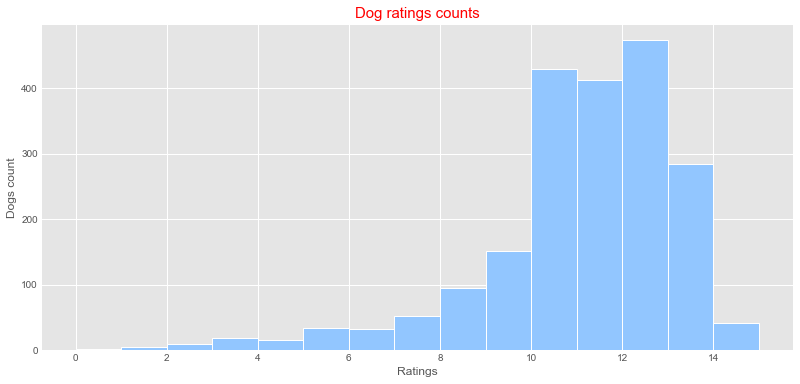

In [223]:
plt.figure(figsize = (12, 6))
plt.style.use('seaborn-pastel')

bins = np.arange(0, 16, 1)
plt.hist(x = archive_clean.rating_numerator, linewidth=1, edgecolor='white', bins=bins)

plt.title('Dog ratings counts', color='red', fontsize=15)
plt.xlabel('Ratings', fontsize=12)
plt.ylabel('Dogs count', fontsize=12)

plt.show()

In [224]:
archive_clean[['retweet_count' , 'favorite_count']].describe()

,retweet_count,favorite_count
count,2073.000000,2073.000000
mean,2976.089243,8556.718283
std,5054.897526,12098.640994
min,16.000000,0.000000
25%,634.000000,1674.000000
50%,1408.000000,3864.000000
75%,3443.000000,10937.000000
max,79515.000000,132810.000000


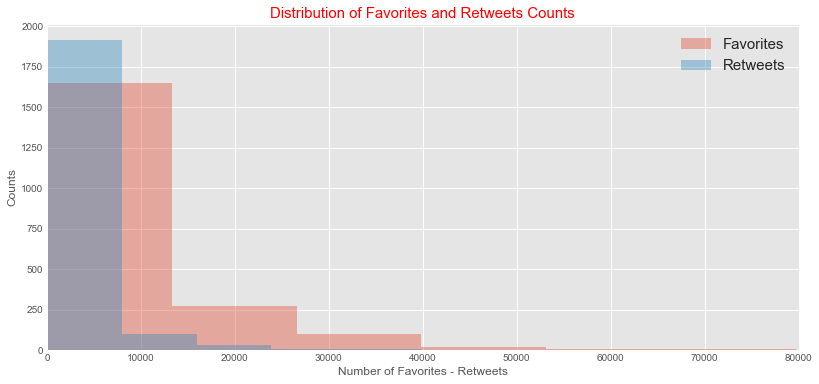

In [225]:
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')
plt.hist(archive_clean.favorite_count, alpha=.4, label='Favorites')
plt.hist(archive_clean.retweet_count, alpha=.4, label='Retweets')

plt.title('Distribution of Favorites and Retweets Counts', color='red', fontsize=15)
plt.xlabel('Number of Favorites - Retweets', fontsize=12)
plt.ylabel('Counts', fontsize=12)

plt.xlim(-1, 80000)

plt.legend(prop={'size': 15})

plt.show()

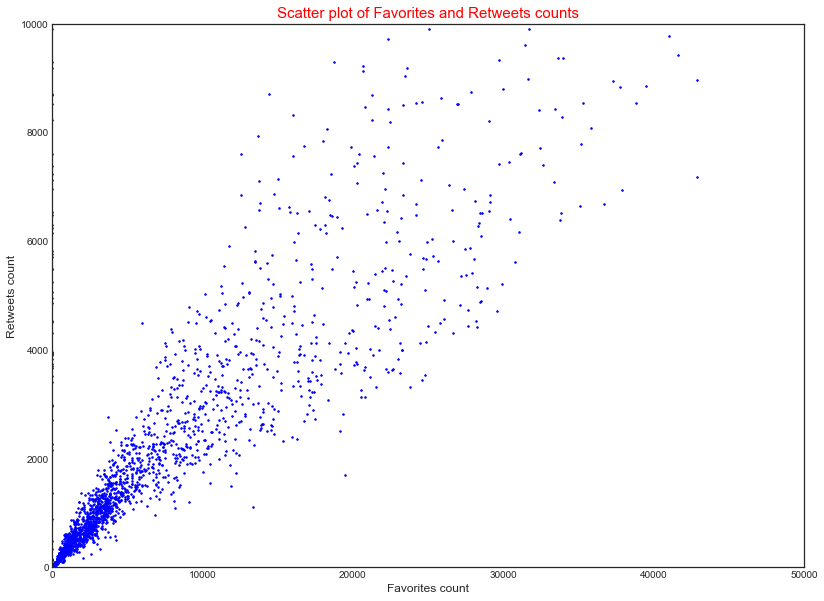

In [226]:
# Scatter plot
plt.figure(figsize=(12, 10))
plt.style.use('seaborn-white')
plt.plot(archive_clean.favorite_count, archive_clean.retweet_count,'bo', markersize=1.5)
plt.title('Scatter plot of Favorites and Retweets counts', color='red', fontsize=15)
plt.xlabel('Favorites count', fontsize=12)
plt.ylabel('Retweets count', fontsize=12)

plt.xlim(0, 50000)
plt.ylim(0, 10000)

plt.show()

In [227]:
#Favorites and retweets analysis by months and days
#code
date_df = archive_clean.copy()
date_df = date_df[['timestamp', 'retweet_count' ,'favorite_count']]

# extract 'month' and 'day' columns from timestamp
date_df['month'] = date_df.timestamp.dt.month_name()
date_df['day'] = date_df.timestamp.dt.day_name()

date_df.sample(5)

,timestamp,retweet_count,favorite_count,month,day
2045,2015-11-28 19:51:59+00:00,266.0,632.0,November,Saturday
343,2017-02-08 22:00:52+00:00,2329.0,11519.0,February,Wednesday
470,2016-12-26 02:00:11+00:00,2090.0,10192.0,December,Monday
262,2017-03-11 18:35:42+00:00,1972.0,9761.0,March,Saturday
564,2016-11-17 01:35:54+00:00,2863.0,9058.0,November,Thursday


In [228]:
# number of favorites and retweets by month
month_df = date_df.groupby('month').sum()
month_df

,retweet_count,favorite_count
month,,
April,334163.0,1190746.0
August,263532.0,681425.0
December,897905.0,2166054.0
February,488213.0,1672341.0
January,803917.0,1971580.0
July,637788.0,2172565.0
June,631483.0,2042654.0
March,503742.0,1535756.0
May,480760.0,1572257.0


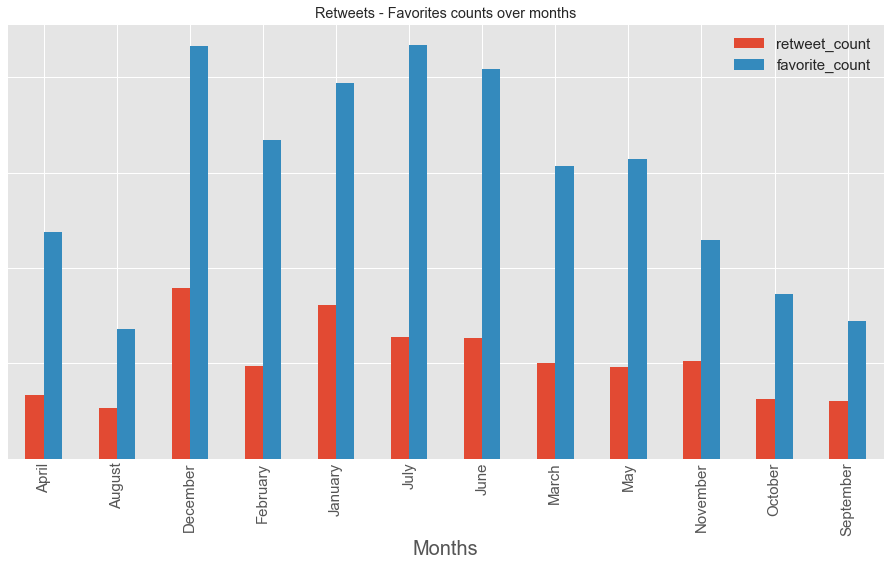

In [280]:
#plot
plt.style.use('ggplot')

ax = month_df[['retweet_count','favorite_count']].plot(kind='bar', title ="Retweets - Favorites counts over months" ,figsize=(14, 8), legend=True, fontsize=15)

ax.set_xlabel("Months", fontsize=20)
ax.set_yticklabels([])

plt.legend(prop={'size':15})

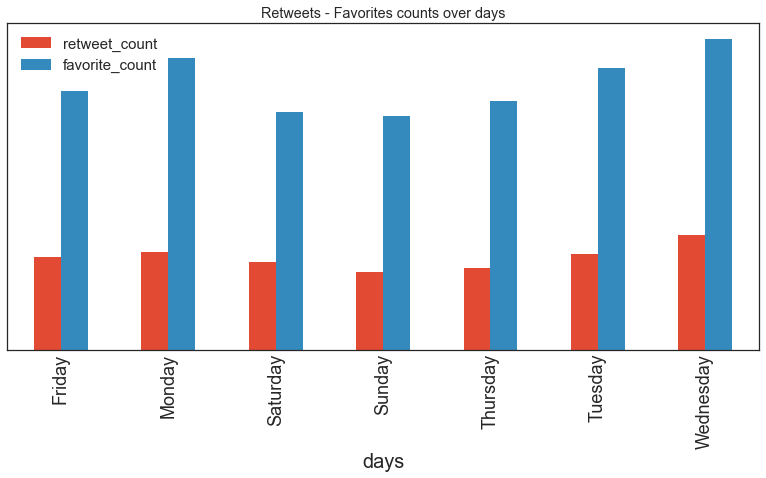

In [229]:
# plot
day_df = date_df.groupby('day').sum()
day_df
ax = day_df[['retweet_count','favorite_count']].plot(kind='bar', title ="Retweets - Favorites counts over days", figsize=(12, 6), legend=True, fontsize=18)

ax.set_xlabel("days", fontsize=20)
ax.set_yticklabels([])

plt.legend(prop={'size':15})


# Dog stage analysis

In [230]:
#Dog stage analysis
#code
# df copy
stage_df = archive_clean.groupby('dog_stage').mean()
stage_df = stage_df[['rating_numerator','retweet_count', 'favorite_count']]
stage_df

,rating_numerator,retweet_count,favorite_count
dog_stage,,,
,12.470353,2771.523103,8164.532230
doggo,11.970149,7901.552239,18200.776119
doggofloofer,11.000000,3433.000000,17169.000000
doggopupper,11.181818,5262.909091,10254.363636
doggopuppo,13.000000,19196.000000,47844.000000
floofer,12.000000,4968.714286,13206.000000
pupper,10.758294,2468.209524,6957.814286
puppo,12.000000,6431.434783,20643.739130


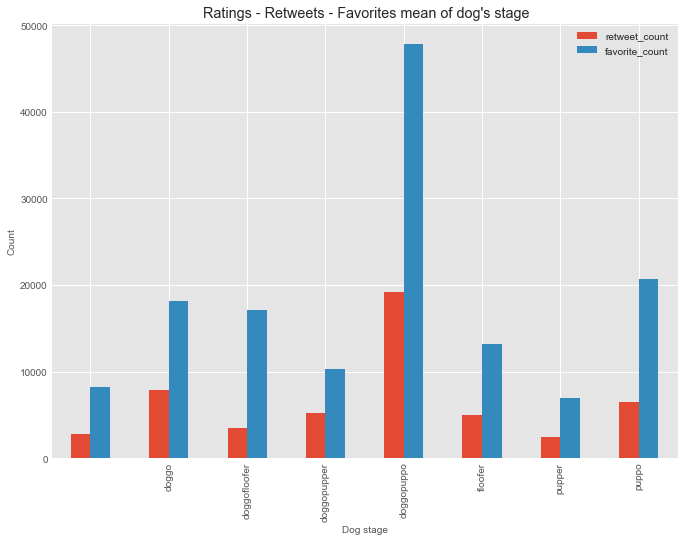

In [285]:
# Plot
ax = stage_df[['retweet_count' , 'favorite_count']].plot(kind='bar', title =" Ratings - Retweets - Favorites mean of dog's stage", figsize=(10, 8), legend=True, fontsize=10)

ax.set_xlabel("Dog stage", fontsize=10)
ax.set_ylabel("Count", fontsize=10)

plt.legend(prop={'size':10})

plt.show()

# Dog breed analysis

In [232]:
# copy of images
images_copy = image_predictions_clean.copy()
images_copy = images_copy[['tweet_id' ,'prediction_1' ,'confidence_1', 'is_dog_1']]
images_copy.shape

(2075, 4)

In [233]:
# copy of archive 
archive_copy = archive_clean.copy()
archive_copy = archive_copy[['tweet_id' , 'rating_numerator' , 'retweet_count' , 'favorite_count']]
archive_copy.shape

(2075, 4)

In [234]:
breed_clean = pd.merge(left=archive_copy, right=images_copy, on='tweet_id')
breed_clean.shape
breed_clean.head()

,tweet_id,rating_numerator,retweet_count,favorite_count,prediction_1,confidence_1,is_dog_1
0,892420643555336193,13,8853.0,39467.0,orange,0.097049,False
1,892177421306343426,13,6514.0,33819.0,Chihuahua,0.323581,True
2,891815181378084864,12,4328.0,25461.0,Chihuahua,0.716012,True
3,891689557279858688,13,8964.0,42908.0,paper_towel,0.170278,False
4,891327558926688256,12,9774.0,41048.0,basset,0.555712,True


In [235]:
# most favs
breed_fav = breed_clean.groupby('prediction_1').sum().reset_index()
breed_fav = breed_fav[['prediction_1', 'favorite_count']]
breed_fav = breed_fav.sort_values('favorite_count', ascending = False)[:20]
breed_fav

,prediction_1,favorite_count
185,golden_retriever,1696627.0
44,Labrador_retriever,1123850.0
58,Pembroke,994755.0
22,Chihuahua,676441.0
64,Samoyed,542991.0
31,French_bulldog,465738.0
137,chow,404241.0
285,pug,320223.0
141,cocker_spaniel,315825.0
59,Pomeranian,299114.0


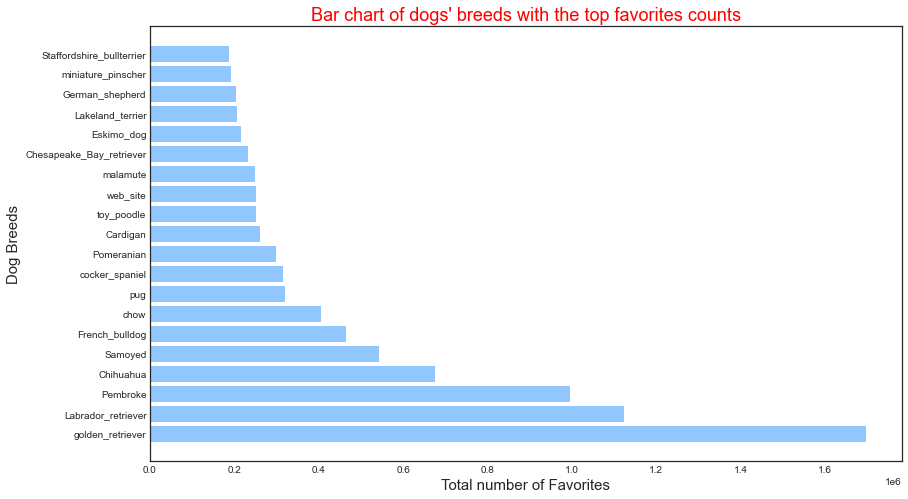

In [237]:
# plot
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-pastel')
plt.barh(range(len(breed_fav.prediction_1)), breed_fav.favorite_count) 

plt.yticks(range(len(breed_fav.prediction_1)), breed_fav.prediction_1)

plt.title('Bar chart of dogs\' breeds with the top favorites counts', color = 'red', fontsize=18)

plt.ylabel('Dog Breeds', fontsize=15)
plt.xlabel('Total number of Favorites',fontsize=15)
plt.show()